In [19]:
!pip install ipython-autotime
%load_ext autotime
!pip install transformers
!pip install -U accelerate
!pip install -U datasets
!pip install seqeval
!pip install evaluate


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 37.6 s (started: 2023-12-16 19:35:14 +00:00)


In [20]:
import pandas as pd
import torch
import numpy as np
import re
import json
import copy
import random
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from transformers import Trainer, AutoTokenizer, AdamW, AutoModelForTokenClassification, TrainingArguments
from datasets import Dataset, DatasetDict, ClassLabel

lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

time: 1.97 ms (started: 2023-12-16 19:35:51 +00:00)


In [21]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

label2id = {'O': 0, 'TABLE': 1, 'TABLEREF': 2, 'ATTR': 3, 'ATTRREF': 4, 'VALUE': 5, 'COND': 6}
id2label = {0: 'O', 1: 'TABLE', 2: 'TABLEREF', 3: 'ATTR', 4: 'ATTRREF', 5: 'VALUE', 6: 'COND'}

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 2.1 s (started: 2023-12-16 19:35:51 +00:00)


Adding special tokens

In [22]:
# Add a new special token
num_added_special_tokend = tokenizer.add_special_tokens({'additional_special_tokens': ['[T]', '[C]']})
print(num_added_special_tokend)

# Resize the token embeddings in the model
model.resize_token_embeddings(len(tokenizer))

# Verify the updated special tokens
print("Updated Special Tokens:")
special_tokens = tokenizer.convert_ids_to_tokens(tokenizer.all_special_ids)
print(special_tokens)


2
Updated Special Tokens:
['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[C]', '[T]']
time: 673 ms (started: 2023-12-16 19:35:53 +00:00)


In [23]:
from google.colab import drive
drive.mount('/content/drive')
dbtagger_dataset_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset'
imdbTrainTypeTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/imdbTrainTag.txt'
imdbTestTypeTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/imdbTestTag.txt'
scholarTrainTypeTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/scholarTrainTag.txt'
scholarTestTypeTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/scholarTestTag.txt'
yelpTrainTypeTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/yelpTrainTag.txt'
yelpTestTypeTag_path = '/content/drive/MyDrive/CS559_shared/implementation/DBTagger_Dataset/yelpTestTag.txt'

spider_tables_json = '/content/drive/MyDrive/CS559_shared/implementation/spider/tables.json'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.14 s (started: 2023-12-16 19:35:54 +00:00)


In [24]:
# Extracting spider database table
spider_table_json_file = open(spider_tables_json)
spider_table_info_list = json.load(spider_table_json_file)
# print(spider_table_info_list)
spider_table_info_dict={}
# print(spider_table_info_list[0]['db_id'])

# storing as a dict
for db_dict in spider_table_info_list:
  if db_dict['db_id'] not in spider_table_info_dict:
    spider_table_info_dict[db_dict['db_id']] = db_dict

print(spider_table_info_dict)


{'perpetrator': {'column_names': [[-1, '*'], [0, 'perpetrator id'], [0, 'people id'], [0, 'date'], [0, 'year'], [0, 'location'], [0, 'country'], [0, 'killed'], [0, 'injured'], [1, 'people id'], [1, 'name'], [1, 'height'], [1, 'weight'], [1, 'home town']], 'column_names_original': [[-1, '*'], [0, 'Perpetrator_ID'], [0, 'People_ID'], [0, 'Date'], [0, 'Year'], [0, 'Location'], [0, 'Country'], [0, 'Killed'], [0, 'Injured'], [1, 'People_ID'], [1, 'Name'], [1, 'Height'], [1, 'Weight'], [1, 'Home Town']], 'column_types': ['text', 'number', 'number', 'text', 'number', 'text', 'text', 'number', 'number', 'number', 'text', 'number', 'number', 'text'], 'db_id': 'perpetrator', 'foreign_keys': [[2, 9]], 'primary_keys': [1, 9], 'table_names': ['perpetrator', 'people'], 'table_names_original': ['perpetrator', 'people']}, 'college_2': {'column_names': [[-1, '*'], [0, 'building'], [0, 'room number'], [0, 'capacity'], [1, 'department name'], [1, 'building'], [1, 'budget'], [2, 'course id'], [2, 'title']

In [25]:
def get_db_tables_and_columns(spider_table_info_dict, db_id):
  db_table_columns_dict = {}
  table_names = spider_table_info_dict[db_id]['table_names_original']
  for table_index in range(len(table_names)):
    table_name = table_names[table_index]
    db_table_columns_dict[table_name] = [col_item[1] for col_item in spider_table_info_dict[db_id]['column_names_original'] if col_item[0] == table_index ]

  return db_table_columns_dict

time: 647 µs (started: 2023-12-16 19:35:56 +00:00)


In [26]:
# examining the get_db_tables_and_columns function
# let say I want to get the tables and their columns in yelp db, imdb db and scholar db
yelp_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'yelp')
imdb_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'imdb')
scholar_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'scholar')

academic_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'academic')
college_1_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'college_1')
hr_1_tables_columns = get_db_tables_and_columns(spider_table_info_dict, 'hr_1')

print('yelp db tables and columns: \n', yelp_tables_columns)
print('imdb db tables and columns: \n', imdb_tables_columns)
print('scholar db tables and columns: \n', scholar_tables_columns)

print('academic db tables and columns: \n', academic_tables_columns)
print('college_1 db tables and columns: \n', college_1_tables_columns)
print('hr_1 db tables and columns: \n', hr_1_tables_columns)

yelp db tables and columns: 
 {'business': ['bid', 'business_id', 'name', 'full_address', 'city', 'latitude', 'longitude', 'review_count', 'is_open', 'rating', 'state'], 'category': ['id', 'business_id', 'category_name'], 'user': ['uid', 'user_id', 'name'], 'checkin': ['cid', 'business_id', 'count', 'day'], 'neighbourhood': ['id', 'business_id', 'neighbourhood_name'], 'review': ['rid', 'business_id', 'user_id', 'rating', 'text', 'year', 'month'], 'tip': ['tip_id', 'business_id', 'text', 'user_id', 'likes', 'year', 'month']}
imdb db tables and columns: 
 {'actor': ['aid', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'copyright': ['id', 'msid', 'cid'], 'cast': ['id', 'msid', 'aid', 'role'], 'genre': ['gid', 'genre'], 'classification': ['id', 'msid', 'gid'], 'company': ['id', 'name', 'country_code'], 'director': ['did', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'producer': ['pid', 'gender', 'name', 'nationality', 'birth_city', 'birth_year'], 'directed_

In [27]:
def retrieve_data_and_tag(path):
    file = open(path, 'r')
    sentences, sentence_tags = [], []
    for line in file:
        # line = re.sub(r"\".*\"","\"xxx\"",line)
        line = re.sub(r"'", "", line)
        word_tag_list = line.split()
        words = []
        tags = []
        for w in word_tag_list:
            item = w.split('/')
            if (len(item[0]) == 0):
                continue

            words.append(item[0])
            if (len(item) < 2):
                print(path, item)
            tags.append(item[1])
        sentences.append(words)
        sentence_tags.append(tags)
        if (len(sentences) != len(sentence_tags)):
            print(line)
    return sentences, sentence_tags

time: 865 µs (started: 2023-12-16 19:35:56 +00:00)


In [28]:
def convert_labels_to_tags(labels_list):
  labels_and_tags = {'O': 0, 'TABLE': 1, 'TABLEREF': 2, 'ATTR': 3, 'ATTRREF': 4, 'VALUE': 5, 'COND': 6, '[T]': -100, '[C]': -100, '[SEP]': -100}
  result = []
  for sublist in labels_list:
    converted_sublist = [labels_and_tags[label] if label in labels_and_tags else 0 for label in sublist ]
    result.append(converted_sublist)
  return result

def convert_tags_to_labels(tags_list):
  tags_and_labels = {0: 'O', 1: 'TABLE', 2: 'TABLEREF', 3: 'ATTR', 4: 'ATTRREF', 5: 'VALUE', 6: 'COND'}
  result = []
  for sublist in tags_list:
    converted_sublist = [tags_and_labels[tag] for tag in sublist]
    result.append(converted_sublist)
  return result

# Examine these functions
input_labels = [['O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O'],
                ['O', 'O', 'O', 'O', 'O', 'TABLE', 'COND', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'COND', 'VALUE', 'O']]
tags = convert_labels_to_tags(input_labels)
print(tags)
labels = convert_tags_to_labels(tags)
print(labels)

[[0, 3, 0, 0, 1, 5, 5, 5, 0, 0], [0, 0, 0, 0, 0, 1, 6, 0, 5, 5, 2, 6, 5, 0]]
[['O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'TABLE', 'COND', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'COND', 'VALUE', 'O']]
time: 2.54 ms (started: 2023-12-16 19:35:56 +00:00)


In [29]:

def split_train_test(question_list, type_tags_list, train_percentage=0.9):
    # Check if the input lists have the same length
    if len(question_list) != len(type_tags_list):
        raise ValueError("Input lists must have the same length")

    # Calculate the number of elements for the training set
    num_train_elements = int(len(question_list) * train_percentage)

    # Generate random indexes for the training set
    train_indexes = random.sample(range(len(question_list)), num_train_elements)

    # Create training and test sets for each list
    train_questions = [question_list[i] for i in train_indexes]
    test_questions = [question_list[i] for i in range(len(question_list)) if i not in train_indexes]

    train_type_tags = [type_tags_list[i] for i in train_indexes]
    test_type_tags = [type_tags_list[i] for i in range(len(type_tags_list)) if i not in train_indexes]

    return (
        train_questions, test_questions,
        train_type_tags, test_type_tags,
    )


time: 818 µs (started: 2023-12-16 19:35:56 +00:00)


In [30]:
# Data preparing
label_names = ['O', 'TABLE', 'TABLEREF', 'ATTR', 'ATTRREF', 'VALUE', 'COND']
imdb_train_queries, imdb_train_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTrainTag.txt")
imdb_test_queries, imdb_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/imdbTestTag.txt")
scholar_train_queries, scholar_train_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTrainTag.txt")
scholar_test_queries, scholar_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/scholarTestTag.txt")
yelp_train_queries, yelp_train_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTrainTag.txt")
yelp_test_queries, yelp_test_type_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/yelpTestTag.txt")

academic_queries, academic_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/Spider/academic/questionsTypeTag2.txt")
academic_train_queries,academic_test_queries, academic_train_tags, academic_test_tags = split_train_test(academic_queries, academic_tags)

college_1_queries, academic_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/Spider/college_1/questionsTypeTag2.txt")
college_1_train_queries,college_1_test_queries, college_1_train_tags, college_1_test_tags = split_train_test(college_1_queries, academic_tags)

hr_1_queries, hr_1_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/Spider/hr_1/questionsTypeTag2.txt")
hr_1_train_queries,hr_1_test_queries, hr_1_train_tags, hr_1_test_tags = split_train_test(hr_1_queries, hr_1_tags)

imdb_2_queries, imdb_2_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/Spider/imdb_2/questionsTypeTag2.txt")
imdb_2_train_queries,imdb_2_test_queries, imdb_2_train_tags, imdb_2_test_tags = split_train_test(imdb_2_queries, imdb_2_tags)

yelp_2_queriess, yelp_2_tags = retrieve_data_and_tag(dbtagger_dataset_path + "/Spider/yelp_2/questionsTypeTag2.txt")
yelp_2_train_queries,yelp_2_test_queries, yelp_2_train_tags, yelp_2_test_tags = split_train_test(yelp_2_queriess, yelp_2_tags)




time: 6.18 s (started: 2023-12-16 19:35:56 +00:00)


In [31]:
# Example with new additioinal special tokens [T] and [C]
print(imdb_train_queries[0])
print(imdb_train_tags[0])

example_query = imdb_train_queries[0].copy()
example_query.append('[SEP]')
for key, value in yelp_tables_columns.items():
  example_query.append('[T]')
  example_query.append(key)
  for column in value:
    example_query.append('[C]')
    example_query.append(column)

print(example_query)
tokenized_text = tokenizer.tokenize(example_query, truncation=True, is_split_into_words=True )
print("Tokenized text: \n", tokenized_text)

['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?']
['O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O']
['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?', '[SEP]', '[T]', 'business', '[C]', 'bid', '[C]', 'business_id', '[C]', 'name', '[C]', 'full_address', '[C]', 'city', '[C]', 'latitude', '[C]', 'longitude', '[C]', 'review_count', '[C]', 'is_open', '[C]', 'rating', '[C]', 'state', '[T]', 'category', '[C]', 'id', '[C]', 'business_id', '[C]', 'category_name', '[T]', 'user', '[C]', 'uid', '[C]', 'user_id', '[C]', 'name', '[T]', 'checkin', '[C]', 'cid', '[C]', 'business_id', '[C]', 'count', '[C]', 'day', '[T]', 'neighbourhood', '[C]', 'id', '[C]', 'business_id', '[C]', 'neighbourhood_name', '[T]', 'review', '[C]', 'rid', '[C]', 'business_id', '[C]', 'user_id', '[C]', 'rating', '[C]', 'text', '[C]', 'year', '[C]', 'month', '[T]', 'tip', '[C]', 'tip_id', '[C]', 'business_id', '[C]', 'text', '[C]', 'user_id', '[C]', '

In [32]:
def serialize_input_queries(query_input_list, query_tag_list,  db_tables_columns_dict):
  serialized_queries = copy.deepcopy(query_input_list)
  serialized_tags = copy.deepcopy(query_tag_list)
  for query_tokens, token_tags in zip(serialized_queries, serialized_tags):
    query_tokens.append('[SEP]')
    token_tags.append('[SEP]')
    # token_tags.append(-100)
    for key, value in db_tables_columns_dict.items():
      # token_tags.append('[SEP]')
      # query_tokens.append('[SEP]')
      query_tokens.append('[T]')
      token_tags.append('[T]')
      # token_tags.append(-100)
      query_tokens.append(key)
      token_tags.append('TABLE')
      for column in value:
        # query_tokens.append('[SEP]')
        # token_tags.append('[SEP]')
        query_tokens.append('[C]')
        token_tags.append('[C]')
        # token_tags.append(-100)
        query_tokens.append(column)
        token_tags.append('ATTR')
  return (serialized_queries, serialized_tags)

time: 811 µs (started: 2023-12-16 19:36:02 +00:00)


In [33]:
# !! Only run 1 time after importing data !!

imdb_train_queries_serialized, imdb_train_tags_serialized = serialize_input_queries(imdb_train_queries, imdb_train_tags, imdb_tables_columns)
imdb_test_queries_serialized, imdb_test_type_tags_serialized = serialize_input_queries(imdb_test_queries, imdb_test_type_tags, imdb_tables_columns)
scholar_train_queries_serialized, scholar_train_tags_serialized = serialize_input_queries(scholar_train_queries, scholar_train_tags, scholar_tables_columns)
scholar_test_queries_serialized, scholar_test_type_tags_serialized =  serialize_input_queries(scholar_test_queries, scholar_test_type_tags, scholar_tables_columns)
yelp_train_queries_serialized, yelp_train_tags_serialized = serialize_input_queries(yelp_train_queries, yelp_train_tags, yelp_tables_columns)
yelp_test_queries_serialized, yelp_test_type_tags_serialized = serialize_input_queries(yelp_test_queries, yelp_test_type_tags, yelp_tables_columns)

academic_train_queries_serialized, academic_train_tags_serialized = serialize_input_queries(academic_train_queries, academic_train_tags, academic_tables_columns)
academic_test_queries_serialized, academic_test_tags_serialized = serialize_input_queries(academic_test_queries, academic_test_tags, academic_tables_columns)
college_1_train_queries_serialized, college_1_train_tags_serialized = serialize_input_queries(college_1_train_queries, college_1_train_tags, college_1_tables_columns)
college_1_test_queries_serialized, college_1_test_tags_serialized = serialize_input_queries(college_1_test_queries, college_1_test_tags, college_1_tables_columns)
hr_1_train_queries_serialized, hr_1_train_tags_serialized = serialize_input_queries(hr_1_train_queries, hr_1_train_tags, hr_1_tables_columns)
hr_1_test_queries_serialized, hr_1_test_tags_serialized = serialize_input_queries(hr_1_test_queries, hr_1_test_tags, hr_1_tables_columns)
imdb_2_train_queries_serialized, imdb_2_train_tags_serialized = serialize_input_queries(imdb_2_train_queries, imdb_2_train_tags, imdb_tables_columns)
imdb_2_test_queries_serialized, imdb_2_test_tags_serialized = serialize_input_queries(imdb_2_test_queries, imdb_2_test_tags, imdb_tables_columns)
yelp_2_train_queries_serialized, yelp_2_train_tags_serialized = serialize_input_queries(yelp_2_train_queries, yelp_2_train_tags, yelp_tables_columns)
yelp_2_test_queries_serialized, yelp_2_test_tags_serialized = serialize_input_queries(yelp_2_test_queries, yelp_2_test_tags, yelp_tables_columns)


# examining serialized queries
print('imdb_train_queries[0]: \n', imdb_train_queries[0])
print('imdb_train_tags[0]: \n', imdb_train_tags[0])
print('imdb_test_queries[0]: \n', imdb_test_queries[0])
print('imdb_test_type_tags[0]: \n', imdb_test_type_tags[0])
print()
print('scholar_train_queries[0]: \n', scholar_train_queries[0])
print('scholar_train_tags[0]: \n', scholar_train_tags[0])
print('scholar_test_queries[0]: \n', scholar_test_queries[0])
print('scholar_test_type_tags[0]: \n', scholar_test_type_tags[0])
print()
print('yelp_train_queries[0]: \n', yelp_train_queries[0])
print('yelp_train_tags[0]: \n', yelp_train_tags[0])
print('yelp_test_queries[0]: \n', yelp_test_queries[0])
print('yelp_test_type_tags[0]: \n', yelp_test_type_tags[0])

#
print('academic_train_queries[0]: \n', academic_train_queries[0])
print('academic_train_tags[0]: \n', academic_train_tags[0])
print('academic_test_queries[0]: \n', academic_test_queries[0])
print('academic_test_tags[0]: \n', academic_test_tags[0])
print()
print('college_1_train_queries[0]: \n', college_1_train_queries[0])
print('college_1_train_tags[0]: \n', college_1_train_tags[0])
print('college_1_test_queries[0]: \n', college_1_test_queries[0])
print('college_1_test_tags[0]: \n', college_1_test_tags[0])
print()
print('hr_1_train_queries[0]: \n', hr_1_train_queries[0])
print('hr_1_train_tags[0]: \n', hr_1_train_tags[0])
print('hr_1_test_queries[0]: \n', hr_1_test_queries[0])
print('hr_1_test_tags[0]: \n', hr_1_test_tags[0])

imdb_train_queries[0]: 
 ['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?']
imdb_train_tags[0]: 
 ['O', 'ATTR', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'O', 'O']
imdb_test_queries[0]: 
 ['find', 'the', 'number', 'of', 'actors', 'from', 'Iran', 'who', 'played', 'in', 'Jim', 'Jarmusch', 'movies']
imdb_test_type_tags[0]: 
 ['O', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'O', 'TABLEREF', 'COND', 'VALUE', 'VALUE', 'TABLE']

scholar_train_queries[0]: 
 ['How', 'many', 'papers', 'does', 'Eric', 'Brewer', 'have', '?']
scholar_train_tags[0]: 
 ['O', 'O', 'TABLE', 'O', 'VALUE', 'VALUE', 'O', 'O']
scholar_test_queries[0]: 
 ['Eric', 'C.', 'Kerrigan', 's', 'Liquid', 'Automatica', 'paper']
scholar_test_type_tags[0]: 
 ['VALUE', 'VALUE', 'VALUE', 'O', 'VALUE', 'VALUE', 'TABLE']

yelp_train_queries[0]: 
 ['find', 'the', 'number', 'of', 'restaurant', 'rated', 'more', 'than', '3.5']
yelp_train_tags[0]: 
 ['O', 'O', 'O', 'O', 'VALUE', 'ATTRREF', 'COND', 'O', 'VALUE']
ye

In [34]:
all_train_queries = imdb_train_queries_serialized + scholar_train_queries_serialized + yelp_train_queries_serialized + academic_train_queries_serialized + college_1_train_queries_serialized + hr_1_train_queries_serialized + imdb_2_train_queries_serialized + yelp_2_train_queries_serialized
all_train_type_tags = imdb_train_tags_serialized + scholar_train_tags_serialized + yelp_train_tags_serialized + academic_train_tags_serialized + college_1_train_tags_serialized + hr_1_train_tags_serialized + imdb_2_train_tags_serialized + yelp_2_train_tags_serialized
all_test_queries = imdb_test_queries_serialized + scholar_test_queries_serialized + yelp_test_queries_serialized + academic_test_queries_serialized + college_1_test_queries_serialized + hr_1_test_queries_serialized + imdb_2_test_queries_serialized + yelp_2_test_queries_serialized
all_test_type_tags = imdb_test_type_tags_serialized + scholar_test_type_tags_serialized + yelp_test_type_tags_serialized + academic_test_tags_serialized + college_1_test_tags_serialized + hr_1_test_tags_serialized + imdb_2_test_tags_serialized + yelp_2_test_tags_serialized

print('all_train_queries[0]: \n', all_train_queries[0])
print('length of all_train_queries: \n', len(all_train_queries))
# print(all_train_type_tags)
# print(len(all_train_type_tags))

all_train_queries[0]: 
 ['What', 'year', 'is', 'the', 'movie', 'Dead', 'Poets', 'Society', 'from', '?', '[SEP]', '[T]', 'actor', '[C]', 'aid', '[C]', 'gender', '[C]', 'name', '[C]', 'nationality', '[C]', 'birth_city', '[C]', 'birth_year', '[T]', 'copyright', '[C]', 'id', '[C]', 'msid', '[C]', 'cid', '[T]', 'cast', '[C]', 'id', '[C]', 'msid', '[C]', 'aid', '[C]', 'role', '[T]', 'genre', '[C]', 'gid', '[C]', 'genre', '[T]', 'classification', '[C]', 'id', '[C]', 'msid', '[C]', 'gid', '[T]', 'company', '[C]', 'id', '[C]', 'name', '[C]', 'country_code', '[T]', 'director', '[C]', 'did', '[C]', 'gender', '[C]', 'name', '[C]', 'nationality', '[C]', 'birth_city', '[C]', 'birth_year', '[T]', 'producer', '[C]', 'pid', '[C]', 'gender', '[C]', 'name', '[C]', 'nationality', '[C]', 'birth_city', '[C]', 'birth_year', '[T]', 'directed_by', '[C]', 'id', '[C]', 'msid', '[C]', 'did', '[T]', 'keyword', '[C]', 'id', '[C]', 'keyword', '[T]', 'made_by', '[C]', 'id', '[C]', 'msid', '[C]', 'pid', '[T]', 'movie'

In [35]:

# combining sentences and tags into a dataframe
all_typeTag_train_data_df = pd.DataFrame({'query_tokens': all_train_queries, 'type_tag_tokens': all_train_type_tags})
all_train_type_tag_values = convert_labels_to_tags(all_typeTag_train_data_df['type_tag_tokens'].tolist())
all_typeTag_train_data_df['type_tag_values']  = all_train_type_tag_values

# seperating training data into train and validation
typeTag_training_data_df = all_typeTag_train_data_df.sample(frac=0.9, random_state=25)
typeTag_validation_data_df = all_typeTag_train_data_df.drop(typeTag_training_data_df.index)
typeTag_training_data_df = typeTag_training_data_df.reset_index(drop=True)
typeTag_validation_data_df = typeTag_validation_data_df.reset_index(drop=True)

typeTag_test_data_df = pd.DataFrame({'query_tokens': all_test_queries, 'type_tag_tokens': all_test_type_tags})
all_test_type_tag_values = convert_labels_to_tags(typeTag_test_data_df['type_tag_tokens'].tolist())
typeTag_test_data_df['type_tag_values']  = all_test_type_tag_values

#check if the separation is done as expected
print(f"No. of training examples: {typeTag_training_data_df.shape[0]}")
print(f"No. of validation examples: {typeTag_validation_data_df.shape[0]}")
print(f"No. of testing examples: {typeTag_test_data_df.shape[0]}")

No. of training examples: 1172
No. of validation examples: 130
No. of testing examples: 244
time: 81.7 ms (started: 2023-12-16 19:36:03 +00:00)


In [36]:
print(typeTag_training_data_df.iloc[0]['query_tokens'])
print(typeTag_training_data_df.iloc[0]['type_tag_tokens'])
print(typeTag_training_data_df.iloc[0]['type_tag_values'])

['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[SEP]', '[T]', 'venue', '[C]', 'venueId', '[C]', 'venueName', '[T]', 'author', '[C]', 'authorId', '[C]', 'authorName', '[T]', 'dataset', '[C]', 'datasetId', '[C]', 'datasetName', '[T]', 'journal', '[C]', 'journalId', '[C]', 'journalName', '[T]', 'keyphrase', '[C]', 'keyphraseId', '[C]', 'keyphraseName', '[T]', 'paper', '[C]', 'paperId', '[C]', 'title', '[C]', 'venueId', '[C]', 'year', '[C]', 'numCiting', '[C]', 'numCitedBy', '[C]', 'journalId', '[T]', 'cite', '[C]', 'citingPaperId', '[C]', 'citedPaperId', '[T]', 'paperDataset', '[C]', 'paperId', '[C]', 'datasetId', '[T]', 'paperKeyphrase', '[C]', 'paperId', '[C]', 'keyphraseId', '[T]', 'writes', '[C]', 'paperId', '[C]', 'authorId']
['O', 'TABLE', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'O', '[SEP]', '[T]', 'TABLE', '[C]', 'ATTR', '[C]', 'ATTR', '[T]', 'TABLE', '[C]', 'ATTR', '[C]', 'ATTR', '[T]', 'TABLE', '[C]', 'ATTR', '[C]', 'ATTR', '[T]', 'TABLE', '[C]', 'ATTR',

In [37]:

# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(typeTag_training_data_df)
validation_dataset = Dataset.from_pandas(typeTag_validation_data_df)
test_dataset = Dataset.from_pandas(typeTag_test_data_df)


time: 116 ms (started: 2023-12-16 19:36:03 +00:00)


In [38]:
# Create DatasetDict
raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['query_tokens', 'type_tag_tokens', 'type_tag_values'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['query_tokens', 'type_tag_tokens', 'type_tag_values'],
        num_rows: 130
    })
    test: Dataset({
        features: ['query_tokens', 'type_tag_tokens', 'type_tag_values'],
        num_rows: 244
    })
})
time: 8.45 ms (started: 2023-12-16 19:36:03 +00:00)


In [39]:
raw_datasets['train'].features

{'query_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'type_tag_tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'type_tag_values': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

time: 7.18 ms (started: 2023-12-16 19:36:03 +00:00)


In [40]:
print("raw_datasets['train'][0]['query_tokens'] \n")
print(raw_datasets["train"][0]["query_tokens"])
print("raw_datasets['train'][0]['type_tag_values'] \n")
print(raw_datasets["train"][0]["type_tag_values"])

raw_datasets['train'][0]['query_tokens'] 

['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[SEP]', '[T]', 'venue', '[C]', 'venueId', '[C]', 'venueName', '[T]', 'author', '[C]', 'authorId', '[C]', 'authorName', '[T]', 'dataset', '[C]', 'datasetId', '[C]', 'datasetName', '[T]', 'journal', '[C]', 'journalId', '[C]', 'journalName', '[T]', 'keyphrase', '[C]', 'keyphraseId', '[C]', 'keyphraseName', '[T]', 'paper', '[C]', 'paperId', '[C]', 'title', '[C]', 'venueId', '[C]', 'year', '[C]', 'numCiting', '[C]', 'numCitedBy', '[C]', 'journalId', '[T]', 'cite', '[C]', 'citingPaperId', '[C]', 'citedPaperId', '[T]', 'paperDataset', '[C]', 'paperId', '[C]', 'datasetId', '[T]', 'paperKeyphrase', '[C]', 'paperId', '[C]', 'keyphraseId', '[T]', 'writes', '[C]', 'paperId', '[C]', 'authorId']
raw_datasets['train'][0]['type_tag_values'] 

[0, 1, 0, 5, 5, 2, 0, 0, -100, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, 

In [41]:
print(tokenizer.is_fast)

True
time: 445 µs (started: 2023-12-16 19:36:03 +00:00)


In [42]:
# examining tokenizer ouput
print('raw_datasets["train"][0]["query_tokens"]: \n', raw_datasets["train"][0]["query_tokens"])
print('raw_datasets["train"][0]["type_tag_tokens"]: \n', raw_datasets["train"][0]["type_tag_tokens"])
print('raw_datasets["train"][0]["type_tag_values"]: \n', raw_datasets["train"][0]["type_tag_values"])
print('length of query_token 0: \n', len(raw_datasets["train"][0]["query_tokens"]))
print('length of type_tag_token 0: \n', len(raw_datasets["train"][0]["query_tokens"]))
print('length of type_tag_values 0: \n', len(raw_datasets["train"][0]["type_tag_values"]))

inputs = tokenizer(raw_datasets["train"][0]["query_tokens"], is_split_into_words=True)
print("inputs => tokenized raw_datasets[train][0]['query_tokens']", inputs)
print('inputs.tokens(): \n', inputs.tokens())
print('inputs.word_ids(): \n', inputs.word_ids())


raw_datasets["train"][0]["query_tokens"]: 
 ['What', 'journals', 'has', 'James', 'Landay', 'published', 'in', '?', '[SEP]', '[T]', 'venue', '[C]', 'venueId', '[C]', 'venueName', '[T]', 'author', '[C]', 'authorId', '[C]', 'authorName', '[T]', 'dataset', '[C]', 'datasetId', '[C]', 'datasetName', '[T]', 'journal', '[C]', 'journalId', '[C]', 'journalName', '[T]', 'keyphrase', '[C]', 'keyphraseId', '[C]', 'keyphraseName', '[T]', 'paper', '[C]', 'paperId', '[C]', 'title', '[C]', 'venueId', '[C]', 'year', '[C]', 'numCiting', '[C]', 'numCitedBy', '[C]', 'journalId', '[T]', 'cite', '[C]', 'citingPaperId', '[C]', 'citedPaperId', '[T]', 'paperDataset', '[C]', 'paperId', '[C]', 'datasetId', '[T]', 'paperKeyphrase', '[C]', 'paperId', '[C]', 'keyphraseId', '[T]', 'writes', '[C]', 'paperId', '[C]', 'authorId']
raw_datasets["train"][0]["type_tag_tokens"]: 
 ['O', 'TABLE', 'O', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'O', '[SEP]', '[T]', 'TABLE', '[C]', 'ATTR', '[C]', 'ATTR', '[T]', 'TABLE', '[C]', 'ATTR', 

In [43]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            # Put the same label
            label = labels[word_id]
            new_labels.append(label)

    return new_labels

time: 707 µs (started: 2023-12-16 19:36:03 +00:00)


In [44]:
# Examining the align_labels_with_tokens

labels = raw_datasets["train"][0]['type_tag_values']
word_ids = inputs.word_ids()
print('labels: \n', labels)
print('length of labels: ', len(labels))
print('word_ids: \n', word_ids)
print('length of word_ids after tokenization: ', len(word_ids))
print()
print('labels before alignment: \n', labels)
print('length of labels before alignment: ', len(labels))
print()
print('labels after alignment: \n', align_labels_with_tokens(labels, word_ids))
print('length of labels after alignment: ', len(align_labels_with_tokens(labels, word_ids)))


labels: 
 [0, 1, 0, 5, 5, 2, 0, 0, -100, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 3, -100, 3, -100, 3, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3]
length of labels:  79
word_ids: 
 [None, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 13, 14, 14, 15, 16, 17, 18, 18, 19, 20, 20, 21, 22, 22, 23, 24, 24, 24, 25, 26, 26, 26, 27, 28, 29, 30, 30, 31, 32, 32, 33, 34, 34, 34, 35, 36, 36, 36, 36, 37, 38, 38, 38, 38, 39, 40, 41, 42, 42, 43, 44, 45, 46, 46, 47, 48, 49, 50, 50, 50, 51, 52, 52, 52, 52, 53, 54, 54, 55, 56, 57, 58, 58, 58, 59, 60, 60, 60, 61, 62, 62, 62, 62, 63, 64, 64, 65, 66, 66, 66, 67, 68, 68, 68, 68, 69, 70, 70, 71, 72, 72, 72, 72, 73, 74, 75, 76, 76, 77, 78, 78, None]
length of word_ids after tokenization:  128

labels before alignment: 
 [0, 1, 0, 5, 5, 2, 0, 0, -100, -

As we can see, our function added the -100 for the two special tokens at the beginning and the end, and a new 0 for our word that was split into two tokens.

To preprocess our whole dataset, we need to tokenize all the inputs and apply align_labels_with_tokens() on all the labels.

In [45]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["query_tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["type_tag_values"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

time: 623 µs (started: 2023-12-16 19:36:03 +00:00)


Note that we haven’t padded our inputs yet; we’ll do that later, when creating the batches with a data collator.

We can now apply all that preprocessing in one go on the other splits of our dataset:

In [46]:
# tokenizing and aligning all dataset
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True, #  function should be applied to batches of examples rather than individual examples
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/1172 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

time: 3.66 s (started: 2023-12-16 19:36:03 +00:00)


In [47]:
print(tokenized_datasets)
print(tokenized_datasets['train'])
print(tokenized_datasets['train'][0]['input_ids'])
print(tokenized_datasets['train'][0]['labels'])
print(tokenized_datasets['train'][0]['token_type_ids'])


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 130
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 244
    })
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1172
})
[101, 2054, 9263, 2038, 2508, 2455, 4710, 2405, 1999, 1029, 102, 30523, 6891, 30522, 6891, 3593, 30522, 6891, 18442, 30523, 3166, 30522, 3166, 3593, 30522, 3166, 18442, 30523, 2951, 13462, 30522, 2951, 13462, 3593, 30522, 2951, 13462, 18442, 30523, 3485, 30522, 3485, 3593, 30522, 3485, 18442, 30523, 3145, 8458, 23797, 30522, 3145, 8458, 23797, 3593, 30522, 3145, 8458, 23797, 18442, 30523, 3259, 30522, 3259, 3593, 30522, 2516, 30522, 6891, 3593, 30522, 2095, 30522, 16371, 12458, 1

To preprocess our whole dataset, we need to tokenize all the inputs and apply align_labels_with_tokens() on all the labels.

Here our labels should be padded the exact same way as the inputs so that they stay the same size, using -100 as a value so that the corresponding predictions are ignored in the loss computation

In [48]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

time: 574 µs (started: 2023-12-16 19:36:07 +00:00)


In [49]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(3)])
batch["labels"]
# when you change the range batch size changes and the corresponding padding changes

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    1,    0,    5,    5,    5,    2,    0,    0, -100, -100,
            1, -100,    3,    3, -100,    3,    3, -100,    1, -100,    3,    3,
         -100,    3,    3, -100,    1,    1, -100,    3,    3,    3, -100,    3,
            3,    3, -100,    1, -100,    3,    3, -100,    3,    3, -100,    1,
            1,    1, -100,    3,    3,    3,    3, -100,    3,    3,    3,    3,
         -100,    1, -100,    3,    3, -100,    3, -100,    3,    3, -100,    3,
         -100,    3,    3,    3, -100,    3,    3,    3,    3, -100,    3,    3,
         -100,    1, -100,    3,    3,    3, -100,    3,    3,    3, -100,    1,
            1,    1,    1, -100,    3,    3, -100,    3,    3,    3, -100,    1,
            1,    1,    1, -100,    3,    3, -100,    3,    3,    3,    3, -100,
            1, -100,    3,    3, -100,    3,    3, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -

time: 22.1 ms (started: 2023-12-16 19:36:07 +00:00)


Let’s compare this to the labels for the first and second elements in our dataset. Observe the differences when data_collator is used. Data_collator allows us to set padding automatically according to the batch.



In [50]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 0, 1, 0, 5, 5, 5, 2, 0, 0, -100, -100, 1, -100, 3, 3, -100, 3, 3, -100, 1, -100, 3, 3, -100, 3, 3, -100, 1, 1, -100, 3, 3, 3, -100, 3, 3, 3, -100, 1, -100, 3, 3, -100, 3, 3, -100, 1, 1, 1, -100, 3, 3, 3, 3, -100, 3, 3, 3, 3, -100, 1, -100, 3, 3, -100, 3, -100, 3, 3, -100, 3, -100, 3, 3, 3, -100, 3, 3, 3, 3, -100, 3, 3, -100, 1, -100, 3, 3, 3, -100, 3, 3, 3, -100, 1, 1, 1, 1, -100, 3, 3, -100, 3, 3, 3, -100, 1, 1, 1, 1, -100, 3, 3, -100, 3, 3, 3, 3, -100, 1, -100, 3, 3, -100, 3, 3, -100]
[-100, 0, 0, 0, 3, 0, 0, 1, 6, 0, 5, 5, 5, 1, -100, -100, 1, -100, 3, -100, 3, 3, -100, 3, -100, 3, 3, -100, 1, -100, 3, -100, 3, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 1, 1, 1, -100, 3, -100, 3, -100, 1, 1, 1, -100, 3, -100, 3, -100, 1, -100, 3, 3, -100, 3, 3, -100, 3, -100, 1, 1, 1, -100, 3, -100, 3, 3, -100, 1, 1, -100, 3, 3, -100, 3, -100, 1, 1, 1, 1, -100, 3, -100, 3, -100, 1, -100, 3, -100, 3, -100, 3, 3, 3, 3, -100, 3, 3, -100, 3, 3, -100, 3, 3, 3, 3, -100, 3, -100, 3, -100, 1, 1, 1,

**METRICS**

To have the Trainer compute a metric every epoch, we will need to define a compute_metrics() function that takes the arrays of predictions and labels, and returns a dictionary with the metric names and values.

The traditional framework used to evaluate token classification prediction is seqeval. To use this metric, we first need to install the seqeval library:

In [51]:
import evaluate

metric = evaluate.load("seqeval")
# metric = evaluate.load("accuracy")

time: 3.68 s (started: 2023-12-16 19:36:07 +00:00)


The compute_metrics() function first takes the argmax of the logits to convert them to predictions (as usual, the logits and the probabilities are in the same order, so we don’t need to apply the softmax). Then we have to convert both labels and predictions from integers to strings. We remove all the values where the label is -100, then pass the results to the metric.compute() method:

In [52]:
all_epoch_accuracy = []
all_epoch_f1 = []
all_epoch_precision = []
all_epoch_recall = []

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print(true_labels)
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

    all_epoch_accuracy.append(all_metrics["overall_accuracy"])
    all_epoch_f1.append(all_metrics["overall_f1"])
    all_epoch_precision.append(all_metrics["overall_precision"])
    all_epoch_recall.append(all_metrics["overall_recall"])

    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

time: 2.16 ms (started: 2023-12-16 19:36:10 +00:00)


In [53]:
model.config.num_labels

7

time: 7.09 ms (started: 2023-12-16 19:36:11 +00:00)


In [54]:
print(tokenized_datasets)
print("-"*30)
print("-"*30)
print(tokenized_datasets['train'][1]['input_ids'])
print(len(tokenized_datasets['train'][1]['input_ids']))
print("-"*31)
print(tokenized_datasets['train'][1]['labels'])
print(len(tokenized_datasets['train'][1]['labels']))
print("-"*31)
print(tokenized_datasets['train'][1]['token_type_ids'])
print(len(tokenized_datasets['train'][1]['token_type_ids']))
print("-"*31)
print(tokenized_datasets['train'][1]['attention_mask'])
print(len(tokenized_datasets['train'][1]['attention_mask']))




DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 130
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 244
    })
})
------------------------------
------------------------------
[101, 2709, 2033, 1996, 22921, 1997, 2169, 3259, 1999, 1996, 1058, 6392, 2497, 3034, 102, 30523, 3166, 30522, 4681, 30522, 2188, 13704, 30522, 2171, 30522, 1051, 3593, 30523, 3034, 30522, 28744, 30522, 2188, 13704, 30522, 2171, 30523, 5884, 30522, 2106, 30522, 2171, 30523, 5884, 1035, 3166, 30522, 4681, 30522, 2106, 30523, 5884, 1035, 3034, 30522, 28744, 30522, 2106, 30523, 3485, 30522, 2188, 13704, 30522, 10147, 2094, 30522, 2171, 30523, 5884, 1035, 3485, 30522, 2106, 30522, 10147, 2094, 30523, 3145, 18351, 30522, 3145, 18

In [55]:
# Print special tokens map
special_tokens_map = tokenizer.special_tokens_map
print("Special Tokens Map:")
print(special_tokens_map)

# Print special tokens
print("\nSpecial Tokens:")
special_tokens = tokenizer.convert_ids_to_tokens(tokenizer.all_special_ids)
print(special_tokens)

Special Tokens Map:
{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[C]', '[T]']}

Special Tokens:
['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[C]', '[T]']
time: 3.29 ms (started: 2023-12-16 19:36:11 +00:00)


In [56]:
from huggingface_hub import notebook_login
import huggingface_hub
hugging_face_token = "YOUR_HF_ACCESS_TOKEN"
huggingface_hub.login(hugging_face_token)

args = TrainingArguments(
    output_dir="./typetag-bert-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id = "alpcaferoglu/bert-finetuned-typetag",
)



Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
time: 208 ms (started: 2023-12-16 19:36:11 +00:00)


In [57]:
print(torch.__version__)

2.1.0+cu121
time: 491 µs (started: 2023-12-16 19:36:11 +00:00)


In [58]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()
trainer.save_model()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.026716,0.984220,0.966576,0.975318,0.992394
2,No log,0.015778,0.985679,0.982984,0.984330,0.995502
3,No log,0.012430,0.989640,0.986934,0.988285,0.996362
4,No log,0.011023,0.991482,0.990277,0.990879,0.997222
5,No log,0.011485,0.990262,0.988757,0.989509,0.996759
6,No log,0.010246,0.990884,0.990884,0.990884,0.997090
7,0.050100,0.010321,0.992703,0.992100,0.992401,0.997354
8,0.050100,0.010711,0.990285,0.991188,0.990737,0.997024
9,0.050100,0.010500,0.993003,0.991796,0.992399,0.997487
10,0.050100,0.010684,0.991185,0.990884,0.991035,0.997222


[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

[['O', 'O', 'O', 'ATTR', 'O', 'VALUE', 'VALUE', 'VALUE', 'O', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

events.out.tfevents.1702755372.804ca84a8927.162.0:   0%|          | 0.00/9.76k [00:00<?, ?B/s]

time: 11min 16s (started: 2023-12-16 19:36:11 +00:00)


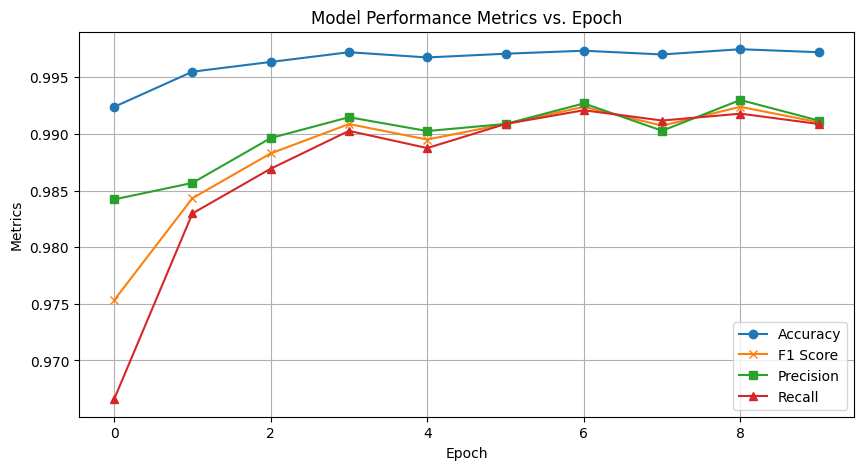

time: 425 ms (started: 2023-12-16 19:47:27 +00:00)


In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(all_epoch_accuracy, marker='o', label='Accuracy')
plt.plot(all_epoch_f1, marker='x', label='F1 Score')
plt.plot(all_epoch_precision, marker='s', label='Precision')
plt.plot(all_epoch_recall, marker='^', label='Recall')
plt.legend()

plt.title('Model Performance Metrics vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.grid(True)
plt.show()

In [60]:
print(trainer)

time: 1.04 ms (started: 2023-12-16 19:47:27 +00:00)


In [61]:
# Accessing the history
history_df = pd.DataFrame(trainer.state.log_history)
print(history_df)

    eval_loss  eval_precision  eval_recall   eval_f1  eval_accuracy  \
0    0.026716        0.984220     0.966576  0.975318       0.992394   
1    0.015778        0.985679     0.982984  0.984330       0.995502   
2    0.012430        0.989640     0.986934  0.988285       0.996362   
3    0.011023        0.991482     0.990277  0.990879       0.997222   
4    0.011485        0.990262     0.988757  0.989509       0.996759   
5    0.010246        0.990884     0.990884  0.990884       0.997090   
6         NaN             NaN          NaN       NaN            NaN   
7    0.010321        0.992703     0.992100  0.992401       0.997354   
8    0.010711        0.990285     0.991188  0.990737       0.997024   
9    0.010500        0.993003     0.991796  0.992399       0.997487   
10   0.010684        0.991185     0.990884  0.991035       0.997222   
11        NaN             NaN          NaN       NaN            NaN   

    eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  ste

In [62]:
# Testing finetuned distil bert
test_dataset = tokenized_datasets["test"]

# Use the trainer to evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print the evaluation results
results

[['O', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'O', 'TABLEREF', 'COND', 'VALUE', 'VALUE', 'VALUE', 'VALUE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'TABLE', 'TABLE', 'TABLE', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR', 'ATTR

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: COND seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VALUE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TABLEREF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ATTR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.

{'eval_loss': 0.009461561217904091,
 'eval_precision': 0.990884985084521,
 'eval_recall': 0.9922004646531696,
 'eval_f1': 0.9915422885572139,
 'eval_accuracy': 0.9969823411072201,
 'eval_runtime': 3.6279,
 'eval_samples_per_second': 67.256,
 'eval_steps_per_second': 4.41,
 'epoch': 10.0}

time: 3.64 s (started: 2023-12-16 19:47:28 +00:00)


In [63]:
# examining one test item
# imdb_train_queries, imdb_train_tags, imdb_tables_columns
example_query = imdb_test_queries[0]
example_query = " ".join(example_query)
print('example_query: ', example_query)
example_query_tags = imdb_test_type_tags[0]
print('example_query_tags: ', example_query_tags)

example_query:  find the number of actors from Iran who played in Jim Jarmusch movies
example_query_tags:  ['O', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'O', 'TABLEREF', 'COND', 'VALUE', 'VALUE', 'TABLE']
time: 1.33 ms (started: 2023-12-16 19:47:31 +00:00)


In [64]:
from transformers import pipeline

# Load the model from the Hugging Face Hub
model = pipeline(task="token-classification", model="alpcaferoglu/bert-finetuned-typetag")



config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


time: 10.4 s (started: 2023-12-16 19:47:31 +00:00)


In [65]:
def post_processing(input_query, predicted_label_list):
  list_of_tokens = input_query.split()

  token_start_indexes = []
  copy_query = input_query
  index = 0
  for token in list_of_tokens:
    index = copy_query.find(token, index)
    token_start_indexes.append(index)
    index += len(token)

  # print('token_start_indexes: ', token_start_indexes)

  predicted_token_start_indexes = [token_dict['start'] for token_dict in predicted_label_list]

  predicted_labels = []
  for token, start_index in zip(list_of_tokens, token_start_indexes):
    if start_index in predicted_token_start_indexes:
      index = predicted_token_start_indexes.index(start_index)
      token_dict = predicted_label_list[index]
      label = token_dict['entity']
      predicted_labels.append(label)
    else:
      label = 'O'
      predicted_labels.append(label)

  return predicted_labels


time: 960 µs (started: 2023-12-16 19:47:42 +00:00)


In [66]:
# Example for a single test item
example_query = imdb_test_queries[1]
example_query = " ".join(example_query)
print('example_query: ', example_query)
example_query_tags = imdb_test_type_tags[1]
print('example_query_tags: ', example_query_tags)
predicted_labels = model(example_query)
print('predicted_labels: ', predicted_labels)
predicted_labels = post_processing(example_query, predicted_labels)
print('predicted_labels_dict: ', predicted_labels)


example_query:  Who is the director of the series House of Cards produced by Netflix ?
example_query_tags:  ['O', 'O', 'O', 'TABLE', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'VALUE', 'O']
predicted_labels:  [{'entity': 'TABLE', 'score': 0.5692998, 'index': 4, 'word': 'director', 'start': 11, 'end': 19}, {'entity': 'TABLE', 'score': 0.52022153, 'index': 7, 'word': 'series', 'start': 27, 'end': 33}, {'entity': 'VALUE', 'score': 0.57991064, 'index': 8, 'word': 'house', 'start': 34, 'end': 39}, {'entity': 'VALUE', 'score': 0.43153372, 'index': 9, 'word': 'of', 'start': 40, 'end': 42}, {'entity': 'VALUE', 'score': 0.6567028, 'index': 10, 'word': 'cards', 'start': 43, 'end': 48}, {'entity': 'TABLE', 'score': 0.23444146, 'index': 11, 'word': 'produced', 'start': 49, 'end': 57}, {'entity': 'VALUE', 'score': 0.5588834, 'index': 13, 'word': 'netflix', 'start': 61, 'end': 68}]
predicted_labels_dict:  ['O', 'O', 'O', 'TABLE', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'TAB

In [67]:
# Example for multiple test items
# we consider whole imdb_test_queries and imdb_test_type_tags
example_queries = imdb_test_queries[:6]
test_labels = imdb_test_type_tags[:6]
test_inputs = [' '.join(token_list) for token_list in example_queries]
test_outputs = model(test_inputs) # returns list of list of objects

for ind in range(len(test_inputs)):
  print('*'*30)
  print('query: ', test_inputs[ind])
  print('query token labels: \n', test_labels[ind])
  predicted_labels = test_outputs[ind]
  predicted_labels = post_processing(test_inputs[ind], predicted_labels)
  print('Predicted labels: \n', predicted_labels)



******************************
query:  find the number of actors from Iran who played in Jim Jarmusch movies
query token labels: 
 ['O', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'O', 'TABLEREF', 'COND', 'VALUE', 'VALUE', 'TABLE']
Predicted labels: 
 ['O', 'O', 'O', 'O', 'TABLE', 'COND', 'VALUE', 'O', 'TABLEREF', 'O', 'VALUE', 'VALUE', 'TABLE']
******************************
query:  Who is the director of the series House of Cards produced by Netflix ?
query token labels: 
 ['O', 'O', 'O', 'TABLE', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'TABLEREF', 'O', 'VALUE', 'O']
Predicted labels: 
 ['O', 'O', 'O', 'TABLE', 'O', 'O', 'TABLE', 'VALUE', 'VALUE', 'VALUE', 'TABLE', 'O', 'VALUE', 'O']
******************************
query:  Find all actors born in Los Angeles
query token labels: 
 ['O', 'O', 'TABLE', 'O', 'COND', 'VALUE', 'VALUE']
Predicted labels: 
 ['O', 'O', 'TABLE', 'O', 'COND', 'VALUE', 'VALUE']
******************************
query:  Find the name and budget of the latest movi

In [68]:
# examining by feeding with serialized queries
# all_test_queries, all_test_type_tags

example_queries = all_test_queries[:6]
test_labels = all_test_type_tags[:6]
test_inputs = [' '.join(token_list) for token_list in example_queries]
test_outputs = model(test_inputs) # returns list of list of objects

for ind in range(len(test_inputs)):
  print('*'*30)
  print('query: ', test_inputs[ind])
  print('query token labels: \n', test_labels[ind])
  predicted_labels = test_outputs[ind]
  predicted_labels = post_processing(test_inputs[ind], predicted_labels)
  print('Predicted labels: \n', predicted_labels)



******************************
query:  find the number of actors from Iran who played in Jim Jarmusch movies [SEP] [T] actor [C] aid [C] gender [C] name [C] nationality [C] birth_city [C] birth_year [T] copyright [C] id [C] msid [C] cid [T] cast [C] id [C] msid [C] aid [C] role [T] genre [C] gid [C] genre [T] classification [C] id [C] msid [C] gid [T] company [C] id [C] name [C] country_code [T] director [C] did [C] gender [C] name [C] nationality [C] birth_city [C] birth_year [T] producer [C] pid [C] gender [C] name [C] nationality [C] birth_city [C] birth_year [T] directed_by [C] id [C] msid [C] did [T] keyword [C] id [C] keyword [T] made_by [C] id [C] msid [C] pid [T] movie [C] mid [C] title [C] release_year [C] title_aka [C] budget [T] tags [C] id [C] msid [C] kid [T] tv_series [C] sid [C] title [C] release_year [C] num_of_seasons [C] num_of_episodes [C] title_aka [C] budget [T] writer [C] wid [C] gender [C] name [C] nationality [C] num_of_episodes [C] birth_city [C] birth_year [T]

time: 3.3 s (started: 2023-12-16 19:47:43 +00:00)
